In [0]:
from google.colab import drive
drive.mount('/content/drive')

#**Part 1 - Data gathering and feature engineering**


**Libraries**

In [0]:
import numpy as np #Linear_Algebra
import matplotlib.pyplot as plt
import pandas as pd #Data_Processing
import pandas_datareader as pdr
from scipy import stats
%matplotlib inline

In [0]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
pip install -q yfinance --upgrade

In [0]:
#Import Yahoo Finance
import yfinance as yf

In [0]:
yf.pdr_override()

In [0]:
#CISCO data
SELECTED_STOCK = 'CSCO'
start = '2010-12-17'
end = '2018-12-17'

In [0]:
#Download NVIDIA stock price data for the past 10 yrs to date
stock_data = pdr.get_data_yahoo(SELECTED_STOCK, start, end)

In [9]:
stock_data.head(10)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-12-17,19.780001,19.500000,19.700001,19.549999,115525000.0,15.245194
2010-12-20,19.719999,19.520000,19.580000,19.620001,49113500.0,15.299781
2010-12-21,19.770000,19.500000,19.639999,19.530001,62386300.0,15.229600
2010-12-22,19.570000,19.510000,19.540001,19.559999,42787100.0,15.252996
2010-12-23,19.760000,19.500000,19.540001,19.690001,41599200.0,15.354370
2010-12-27,20.400000,19.809999,19.840000,20.160000,62054900.0,15.720881
2010-12-28,20.510000,20.280001,20.370001,20.350000,57275400.0,15.869036
2010-12-29,20.510000,20.250000,20.490000,20.250000,32977000.0,15.791062
2010-12-30,20.350000,20.209999,20.320000,20.230000,25576700.0,15.775463


**Feature Engineering**

In [10]:
#Getting the Open price
stock_data_open = stock_data.Open.values
reshaped_stock_data_open = np.reshape(stock_data_open, (-1, 1))
reshaped_stock_data_open

array([[19.70000076],
       [19.57999992],
       [19.63999939],
       ...,
       [47.68000031],
       [46.36999893],
       [45.81999969]])

In [11]:
#validity check
np.mean(reshaped_stock_data_open)==np.mean(stock_data_open)

True

#**Backtesting**

>I'll be using **Zipline**, a backtesting framework


In [0]:
pip install -c Quantopian zipline 

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import zipline
from yahoofinancials import YahooFinancials
import warnings

##**Simple Moving Average Strategy**

In [0]:
%%zipline --start 2010-12-17 --end 2018-12-17 --capital-base 1050.0 -o sma_strategy.pkl

# imports 
from zipline.api import order_target, record, symbol
from zipline.finance import commission
import matplotlib.pyplot as plt
import numpy as np

# parameters 
ma_periods = 20
selected_stock = 'AAPL'
n_stocks_to_buy = 10

def initialize(context):
    context.time = 0
    context.asset = symbol(selected_stock)
    # 1. manually setting the commission
    context.set_commission(commission.PerShare(cost=0.001, min_trade_cost=0))

def handle_data(context, data):
    # 2. warm-up period
    context.time += 1
    if context.time < ma_periods:
        return

    # 3. access price history
    price_history = data.history(context.asset, fields="price", bar_count=ma_periods, frequency="1d")
 
    # 4. calculate moving averages
    ma = price_history.mean()
    
    # 5. trading logic
    
    # cross up
    if (price_history[-2] < ma) & (price_history[-1] > ma):
        order_target(context.asset, n_stocks_to_buy)
    # cross down
    elif (price_history[-2] > ma) & (price_history[-1] < ma):
        order_target(context.asset, 0)

    # save values for later inspection
    record(price=data.current(context.asset, 'price'),
           moving_average=ma)
    
# 6. analyze block
def analyze(context, perf):
    fig, ax = plt.subplots(3, 1, sharex=True, figsize=[16, 9])

    # portfolio value
    perf.portfolio_value.plot(ax=ax[0])
    ax[0].set_ylabel('portfolio value in $')
    
    # asset
    perf[['price', 'moving_average']].plot(ax=ax[1])
    ax[1].set_ylabel('price in $')
    
    # mark transactions
    perf_trans = perf.loc[[t != [] for t in perf.transactions]]
    buys = perf_trans.loc[[t[0]['amount'] > 0 for t in perf_trans.transactions]]
    sells = perf_trans.loc[[t[0]['amount'] < 0 for t in perf_trans.transactions]]
    ax[1].plot(buys.index, perf.price.loc[buys.index], '^', markersize=10, color='g', label='buy')
    ax[1].plot(sells.index, perf.price.loc[sells.index], 'v', markersize=10, color='r', label='sell')
    ax[1].legend()
    
    # daily returns
    perf.returns.plot(ax=ax[2])
    ax[2].set_ylabel('daily returns')

    fig.suptitle('Simple Moving Average Strategy - Apple', fontsize=16)
    plt.legend()
    plt.show()
    
    print('Final portfolio value (including cash): {}$'.format(np.round(perf.portfolio_value[-1], 2)))

**Feature Scaling**

In [0]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
scaled_data = sc.fit_transform(reshaped_stock_data_open)

In [0]:
def timestamp(n_period, scaled_data):
    x_train = [] 
    y_train = [] #1 output to predict

    for i in range(n_period,len(scaled_data)):
        x_train.append(scaled_data[i-n_period:i,0])
        y_train.append(scaled_data[i,0])
    x_train, y_train = np.array(x_train), np.array(y_train)

    #reshaping
    x_train_ = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    return x_train_, x_train, y_train

In [0]:
x_train_, x_train, y_train = timestamp(60, scaled_data)

#**Part 2 - Model Identification**

##**Decision Tree (Regression)**

In [27]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor()
decision_tree_regr = BaggingRegressor(dt, n_estimators=10, random_state=0)
decision_tree_regr.fit(x_train, y_train)

BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                      max_depth=None,
                                                      max_features=None,
                                                      max_leaf_nodes=None,
                                                      min_impurity_decrease=0.0,
                                                      min_impurity_split=None,
                                                      min_samples_leaf=1,
                                                      min_samples_split=2,
                                                      min_weight_fraction_leaf=0.0,
                                                      presort=False,
                                                      random_state=None,
                                                      splitter='best'),
                 bootstrap=True, bootstrap_features=False, max_features=1.0,
                 max_sample

##**Recurrent Neural Network (RNN)**

In [0]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [0]:
#Importing the keras libraries and packages
from tensorflow.python.keras.layers import Dense, LSTM, Dropout
from tensorflow.python.keras import Sequential

In [30]:
regressor = Sequential()

#Adding the first LSTM Layer and some Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape = (x_train_.shape[1], 1)))
regressor.add(Dropout(rate = 0.2))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [31]:
x_train.shape[1]

60

In [0]:
#Adding the second LSTM Layer and some Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(rate = 0.2))

In [0]:
#Adding the third LSTM Layer and some Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(rate = 0.2))

In [0]:
#Adding the fourth LSTM Layer and some Dropout regularisation
regressor.add(LSTM(units=50))
regressor.add(Dropout(rate = 0.2))

In [0]:
#Adding the output layer
regressor.add(Dense(units=1))

In [0]:
#compiling the RNN
regressor.compile(optimizer='adam', loss='mean_squared_error')

In [38]:
#fitting the RNN to the training set
regressor.fit(x_train_, y_train, epochs=50, batch_size = 32)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 1953 samples
Epoch 1/50
1953/1953 [==============================] - 34s 17ms/sample - loss: 0.0184
Epoch 2/50
1953/1953 [==============================] - 27s 14ms/sample - loss: 0.0031
Epoch 3/50
1953/1953 [==============================] - 27s 14ms/sample - loss: 0.0031
Epoch 4/50
1953/1953 [==============================] - 27s 14ms/sample - loss: 0.0027
Epoch 5/50
1953/1953 [==============================] - 27s 14ms/sample - loss: 0.0033
Epoch 6/50
1953/1953 [==============================] - 27s 14ms/sample - loss: 0.0030
Epoch 7/50
1953/1953 [==============================] - 27s 14ms/sample - loss: 0.0026
Epoch 8/50
1953/1953 [==============================] - 27s 14ms/sample - loss: 0.0023
Epoch 9/50
1953/1953 [==============================] - 27s 14ms/sample - loss: 0.0035
Epoch 10/50
1953/1953 [==============================] - 27s 14ms/sample - loss: 0.0024
Epoch 11/50
1

**Save the model**

In [0]:
regressor = regressor.save("regressor.h5")

**Load the model**

In [40]:
from tensorflow.python.keras.models import load_model

regressor = load_model("regressor.h5")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


##**Making the predictions and visualising the results**

In [0]:
# Getting the real/test stock price of 2019
test_stock_data = pdr.get_data_yahoo(SELECTED_STOCK, start = '2018-12-18', end = '2019-12-17')
real_stock_price = test_stock_data.iloc[:, 1:2].values

In [0]:
dataset_total = pd.concat((stock_data['Open'], test_stock_data['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test_stock_data) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

In [0]:
X_test = []
for i in range(60, 310): #80 because we're predicting 20 records
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [0]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price) #retranform the output because our input data was scaled between 0 and 1.

Text(0.5, 1.0, 'CISCO Stock Price Prediction')

Text(0.5, 0, 'Time')

Text(0, 0.5, 'CISCO Stock Price')

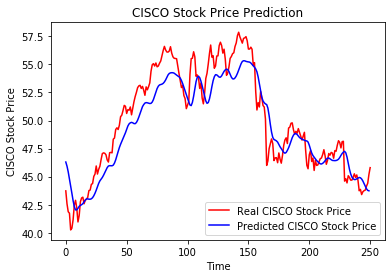

In [58]:
# Visualising the results
plt.plot(real_stock_price, color = 'red', label = 'Real CISCO Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted CISCO Stock Price')
plt.title('CISCO Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('CISCO Stock Price')
plt.legend()
plt.show()